# Luftqualitätsdaten: Import, Transformation & Excel-Export

Dieses Notebook führt folgende Schritte aus:
1. **Extraktion** von CSV-Daten aus verschachtelten ZIP-Archiven.
2. **Bereinigung** und Kombination der Zeitstempel.
3. **Pivotierung** in ein Analyse-freundliches Format (Wide-Format).
4. **Export** der Ergebnisse in eine Excel-Datei.

In [1]:
import pandas as pd
import os
import zipfile

data_dir = 'raw_data'
li = []

if not os.path.exists(data_dir):
    print(f"Ordner '{data_dir}' nicht gefunden. Bitte erstellen.")
else:
    for zip_filename in os.listdir(data_dir):
        if zip_filename.endswith(".zip"):
            zip_path = os.path.join(data_dir, zip_filename)
            with zipfile.ZipFile(zip_path, "r") as z:
                for member_path in z.namelist():
                    if member_path.endswith(".csv") and "__MACOSX" not in member_path:
                        try:
                            with z.open(member_path) as f:
                                df_temp = pd.read_csv(
                                    f, 
                                    sep=';', 
                                    decimal=',', 
                                    encoding='utf-8'
                                )
                                li.append(df_temp)
                        except Exception as e:
                            print(f"Fehler bei {member_path}: {e}")

    if li:
        df = pd.concat(li, axis=0, ignore_index=True).drop_duplicates()
        print(f"Erfolgreich geladen: {len(df)} Zeilen.")
    else:
        print("Keine Daten gefunden.")

Erfolgreich geladen: 16199386 Zeilen.


## Daten transformieren

In [2]:
if 'df' in locals() and not df.empty:
    # Zeitstempel konvertieren
    df['Timestamp'] = pd.to_datetime(df['Datum'] + ' ' + df['Uhrzeit'], dayfirst=True, errors='coerce')
    
    # Pivotieren (Schadstoffe in Spalten)
    index_cols = ['Stationscode', 'Stationsname', 'Stationsumgebung', 'Art der Station', 'Timestamp', 'Einheit']
    df_wide = df.pivot_table(
        index=index_cols, 
        columns='Schadstoff', 
        values='Messwert',
        aggfunc='first'
    ).reset_index()
    
    df_wide.columns.name = None
    display(df_wide.head())

,Stationscode,Stationsname,Stationsumgebung,Art der Station,Timestamp,Einheit,Feinstaub (PM₁₀),"Feinstaub (PM₂,₅)",Kohlenmonoxid (CO),Ozon (O₃),Schwefeldioxid (SO₂),Stickstoffdioxid (NO₂)
0,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 01:00:00,µg/m³,-,-,NaN,54,4,8
1,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 02:00:00,µg/m³,-,-,NaN,59,2,4
2,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 03:00:00,µg/m³,-,-,NaN,59,1,4
3,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 04:00:00,µg/m³,-,-,NaN,60,1,4
4,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 05:00:00,µg/m³,-,-,NaN,61,"0,8",4


## Export nach Excel
Wir speichern die bereinigten Daten nun als `.xlsx` Datei ab.

In [3]:
#output_file = "Luftqualitaet_Zusammenfassung.xlsx"
output_file = "Luftqualitaet_Zusammenfassung.csv"

try:
    # index=False verhindert, dass die Zeilennummern von Pandas mitgespeichert werden
    # df_wide.to_excel(output_file, index=False, engine='openpyxl')
    df_wide.to_csv(output_file, sep=';', index=False, encoding='utf-8')
    print(f"✅ Datei erfolgreich gespeichert: {output_file}")
except Exception as e:
    print(f"❌ Fehler beim Speichern: {e}")

✅ Datei erfolgreich gespeichert: Luftqualitaet_Zusammenfassung.csv


In [1]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. DATEN EINLESEN
# =========================

data_dir = "raw_data_2"
li = []

# Prüfen, ob der Ordner existiert
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Der Ordner '{data_dir}' wurde nicht gefunden.")

for filename in os.listdir(data_dir):
    if filename.endswith(".zip"):
        zip_path = os.path.join(data_dir, filename)
        
        try:
            with zipfile.ZipFile(zip_path, "r") as z:
                for csv_filename in z.namelist():
                    # FILTER: Ignoriere MacOS Metadaten-Dateien und Ordner
                    if "__MACOSX" in csv_filename or os.path.basename(csv_filename).startswith("._"):
                        continue
                    
                    if csv_filename.endswith(".csv"):
                        try:
                            df_temp = pd.read_csv(
                                z.open(csv_filename),
                                sep=";",
                                decimal=",",
                                encoding="utf-8",
                                low_memory=False # Verhindert DtypeWarnings bei gemischten Typen
                            )
                            li.append(df_temp)
                        except Exception as e:
                            print(f"⚠️ Fehler beim Lesen von {csv_filename} in {filename}: {e}")
        except zipfile.BadZipFile:
            print(f"❌ Die Datei {filename} ist beschädigt und kann nicht geöffnet werden.")

if not li:
    raise ValueError("❌ Keine gültigen CSV-Daten gefunden!")

df = pd.concat(li, ignore_index=True)
print(f"✅ Daten geladen: {len(df)} Zeilen")

✅ Daten geladen: 4422469 Zeilen


In [ ]:
# =========================
# 2. SPALTEN AUFBEREITEN
# =========================

# Spalten umbenennen
# Hinweis: NO2 ist Stickstoffdioxid. NO3 wäre Nitrat. Habe es hier auf NO2 korrigiert.
df = df.rename(columns={
    "Feinstaub (PM₁₀)": "PM10",
    "Feinstaub (PM₂,₅)": "PM25",
    "Kohlenmonoxid (CO)": "CO",
    "Ozon (O₃)": "O3",
    "Schwefeldioxid (SO₂)": "SO2",
    "Stickstoffdioxid (NO₂)": "NO2", 
})

pollutants = ["PM10", "PM25", "CO", "O3", "SO2", "NO2"]

# Prüfen, ob alle Spalten vorhanden sind, fehlende Spalten mit NaN auffüllen
for col in pollutants:
    if col not in df.columns:
        df[col] = float("nan")

# In numerische Werte umwandeln
for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Timestamp in datetime umwandeln
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Zeilen ohne gültigen Timestamp oder Stationscode entfernen, um Fehler beim Sortieren zu vermeiden
# df = df.dropna(subset=["Stationscode", "Timestamp"])

In [11]:
# =========================
# 3. SORTIEREN & INTERPOLIEREN
# =========================

# Wichtig für Zeitinterpolation
df = df.sort_values(by=["Stationscode", "Timestamp"])

# Interpolation pro Station
# FIX: Verwendung von 'transform' statt 'apply', um Index-Probleme zu vermeiden
# transform garantiert, dass der Output denselben Index wie der Input hat.
#df[pollutants] = (
#    df.groupby("Stationscode")[pollutants]
#      .transform(lambda x: x.interpolate(method="linear"))
#)

In [4]:
# =========================
# 4. HEATMAP VORBEREITEN
# =========================

# Daten für Heatmap aggregieren
heatmap_df = (
    df.groupby("Stationsname")[pollutants]
      .mean()
      .round(2)
)


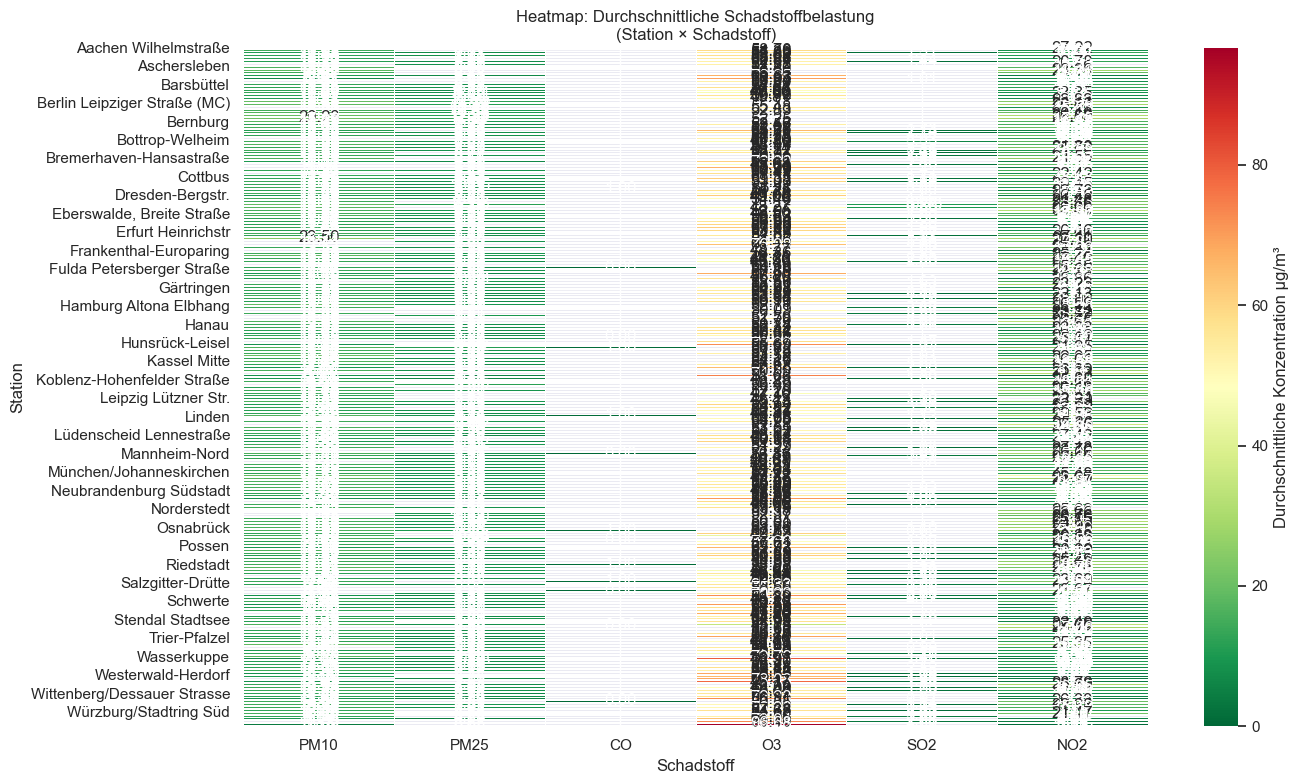

In [12]:

    # =========================
    # 5. HEATMAP VISUALISIEREN
    # =========================
# Prüfen, ob Daten für die Heatmap vorhanden sind
if heatmap_df.empty:
    print("⚠️ Warnung: Heatmap-DataFrame ist leer. Überprüfe die Daten.")
else:
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heatmap_df,
        cmap="RdYlGn_r", # Rot für hoch (schlecht), Grün für niedrig (gut)
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Durchschnittliche Konzentration µg/m³"}
    )

    plt.title("Heatmap: Durchschnittliche Schadstoffbelastung\n(Station × Schadstoff)")
    plt.xlabel("Schadstoff")
    plt.ylabel("Station")
    plt.tight_layout()
    plt.show()

In [13]:
# =========================
# 6. OPTIONAL: KONTROLLAUSGABE
# =========================

print("\n📊 Beispiel: interpolierte Daten (Top 5 Zeilen)")
# Nur Zeilen anzeigen, wenn die Station existiert
beispiel_station = "Aachen-Burtscheid"
if beispiel_station in df["Stationsname"].values:
    print(df[df["Stationsname"] == beispiel_station][["Timestamp"] + pollutants].head())
else:
    print(f"Station '{beispiel_station}' nicht in den Daten gefunden. Zeige erste 5 Zeilen allgemein:")
    print(df[["Stationsname", "Timestamp"] + pollutants].head())


📊 Beispiel: interpolierte Daten (Top 5 Zeilen)
                  Timestamp  PM10  PM25  CO    O3  SO2  NO2
2848582 2023-01-01 01:00:00  59.0   NaN NaN  63.0  NaN  4.0
2848583 2023-01-01 02:00:00   9.0   NaN NaN  61.0  NaN  1.0
2848584 2023-01-01 03:00:00   8.0   NaN NaN  61.0  NaN  2.0
2848585 2023-01-01 04:00:00  13.0   NaN NaN  62.0  NaN  2.0
2848586 2023-01-01 05:00:00  10.0   NaN NaN  64.0  NaN  1.0


In [15]:
print([pollutants])

[['PM10', 'PM25', 'CO', 'O3', 'SO2', 'NO2']]


In [20]:
df['Date'] = df['Timestamp'].dt.date

df['Hour'] = df['Timestamp'].dt.hour

sns.set_theme()

pm10 = df.pivot(index='Stationsname', columns='Hour', values='PM10')

sns.heatmap(
        pm10 ,
        ax=axes[1,1],
        cmap='YlOrRd',
    )

ValueError: Index contains duplicate entries, cannot reshape